In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
import matplotlib as mpl

In [4]:
# Get all the descriptions and labels
file_path = '../cuisines_data/cuisines_data_raw.txt'
cuisines_set = set()
descriptions = []
labels = []
with open(file_path, mode='r', encoding='utf-8') as file:
    for line in file:
        label = line.split(',')[0]
        loc = line.find(',')
        descriptions.append(line[loc+1:].strip())
        labels.append(label)
        cuisines_set.add(label)
cuisines = list(cuisines_set)
cuisines.sort()
descriptions = np.array(descriptions)
labels = np.array(labels)

# Balance the data
class_counts = Counter(labels)
majority_count = max(class_counts.values())
minority_ratio = 0.5
resampled_descriptions = []
resampled_labels = []
for class_label, count in class_counts.items():
    target_count = int(majority_count * minority_ratio) if count < majority_count else count
    resampled_class_descriptions, resampled_class_labels = resample(
        descriptions[labels == class_label],
        labels[labels == class_label],
        replace=True,
        n_samples=target_count,
    )
    resampled_descriptions.extend(resampled_class_descriptions)
    resampled_labels.extend(resampled_class_labels)
descriptions = np.array(resampled_descriptions)
labels = np.array(resampled_labels)

# Tokenize
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(descriptions)
sequences = tokenizer.texts_to_sequences(descriptions)
padded_sequences = pad_sequences(sequences, padding='post')

# Encode labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.3, stratify=encoded_labels)

# Check lengths are correct
len(X_train), len(X_test), len(y_train), len(y_test)

(176492, 75640, 176492, 75640)

In [7]:
# Design model
model = tf.keras.Sequential()
model.add(Embedding(10000, 100, input_length=padded_sequences.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(len(encoder.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/10
5516/5516 [==============================] - 19s 3ms/step - loss: 0.6773 - accuracy: 0.7643 - val_loss: 0.5856 - val_accuracy: 0.8011
Epoch 2/10
5516/5516 [==============================] - 43s 8ms/step - loss: 0.6773 - accuracy: 0.7632 - val_loss: 0.5650 - val_accuracy: 0.8079
Epoch 3/10
5516/5516 [==============================] - 38s 7ms/step - loss: 0.6755 - accuracy: 0.7633 - val_loss: 0.5811 - val_accuracy: 0.8016
Epoch 4/10
5516/5516 [==============================] - 28s 5ms/step - loss: 0.6724 - accuracy: 0.7652 - val_loss: 0.5665 - val_accuracy: 0.8078
Epoch 5/10
5516/5516 [==============================] - 22s 4ms/step - loss: 0.6732 - accuracy: 0.7652 - val_loss: 0.5718 - val_accuracy: 0.8043
Epoch 6/10
5516/5516 [==============================] - 26s 5ms/step - loss: 0.6708 - accuracy: 0.7666 - val_loss: 0.5707 - val_accuracy: 0.8056
Epoch 7/10
5516/5516 [==============================] - 33s 6ms/step - loss: 0.6664 - accuracy: 0.7679 - val_loss: 0.5686 - val_ac

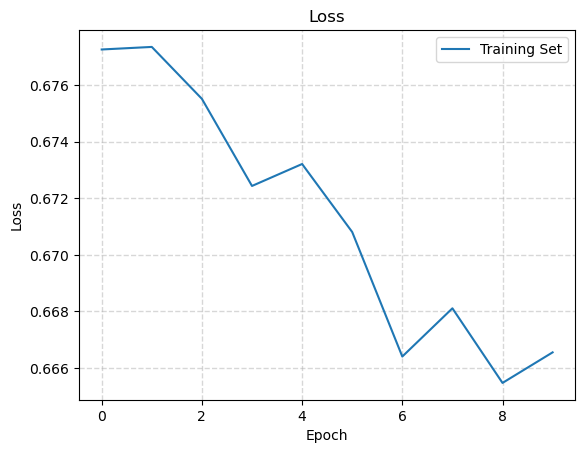

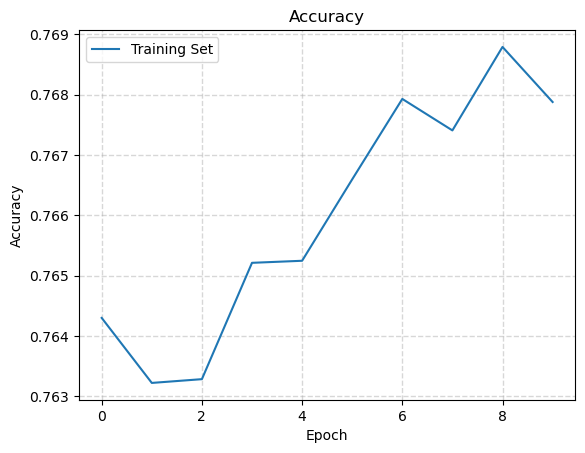

In [11]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
def loss_visualization(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training Set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
loss_visualization(history)

def accuracy_visualization(training_history):
    accuracy = training_history.history['accuracy']
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training Set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
accuracy_visualization(history)


2364/2364 [==============================] - 3s 1ms/step


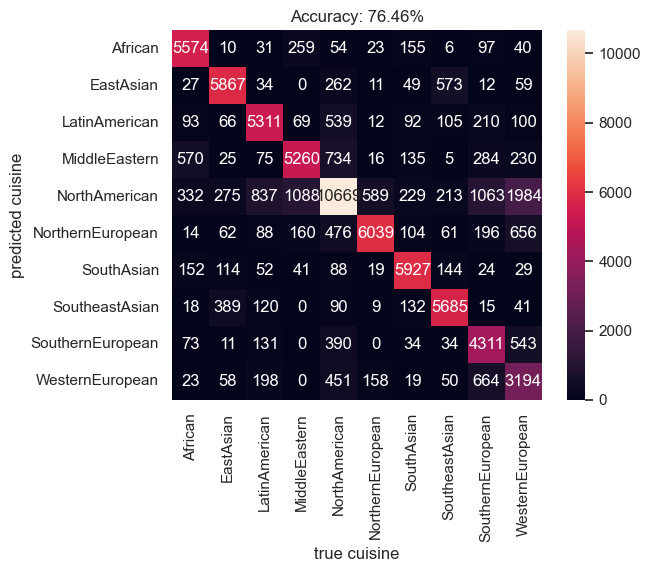

In [7]:
# Create confusion matrix and heat map
y_pred = np.argmax(model.predict(X_test), axis=1)
mat = confusion_matrix(y_test, y_pred)
sns.set(rc={'font.weight': 'normal'})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', xticklabels=cuisines, yticklabels=cuisines)

# Accuracy
correct_predictions = np.sum(y_pred == y_test)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Plotting Heatmap of Confusion Matrix
plt.title('Accuracy: {:.2f}%'.format(accuracy * 100))
plt.xlabel('true cuisine')
plt.ylabel('predicted cuisine')
plt.show()


In [6]:
def predict_cuisine(recipe):
    # Tokenize and pad the input description
    sequence = tokenizer.texts_to_sequences([recipe])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=padded_sequences.shape[1])
    
    # Make a prediction
    prediction = model.predict(padded_sequence)
    
    # Get the index of the maximum value (highest probability)
    predicted_index = np.argmax(prediction)
    
    # Decode the predicted label using the LabelEncoder
    predicted_label = encoder.inverse_transform([predicted_index])[0]
    
    return predicted_label

In [40]:
# Test the model from cleanser.ipynb cleaned recipes
with open('../recipes_data/recipes_filtered.txt', mode='r', encoding='utf-8') as file:
    recipes = file.readlines()

# Test 10 random recipes
import random
recipeArray = []
cuisineArray = []
for i in range(10):
    recipe = random.choice(recipes)
    print('Recipe: ' + recipe[:-1])
    recipeArray.append(recipe[:-1])
    print('Predicted cuisine: ' + predict_cuisine(recipe))
    cuisineArray.append(predict_cuisine(recipe))
    print('')

df = pd.DataFrame({
    "Recipe": [recipeArray[0].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[1].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[2].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[3].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[4].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[5].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[6].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[7].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[8].split("~~~~")[0][6:].replace("~~", ""), 
               recipeArray[9].split("~~~~")[0][6:].replace("~~", "")],

    "Ingredients": [recipeArray[0].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[1].split("~~~~")[1][12:].replace("~~", ""),
                    recipeArray[2].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[3].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[4].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[5].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[6].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[7].split("~~~~")[1][12:].replace("~~", ""),
                    recipeArray[8].split("~~~~")[1][12:].replace("~~", ""), 
                    recipeArray[9].split("~~~~")[1][12:].replace("~~", "")],

    "Instructions": [recipeArray[0].split("~~~~")[2][13:].replace("~~", ""),
                     recipeArray[1].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[2].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[3].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[4].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[5].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[6].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[7].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[8].split("~~~~")[2][13:].replace("~~", ""), 
                     recipeArray[9].split("~~~~")[2][13:].replace("~~", "")],

    "Predicted Cuisine": [cuisineArray[0],
                          cuisineArray[1],
                          cuisineArray[2],
                          cuisineArray[3],
                          cuisineArray[4],
                          cuisineArray[5],
                          cuisineArray[6],
                          cuisineArray[7],
                          cuisineArray[8],
                          cuisineArray[9]]
})
df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["Recipe1", "Recipe2", "Recipe3", "Recipe4", "Recipe5", "Recipe6", "Recipe7", "Recipe8", "Recipe9", "Recipe10"], axis=0)


Recipe: TITLE: Apple Crisp IV~~~~INGREDIENTS:~~- 2 cups all-purpose flour ~~- 2 cups rolled oats ~~- 1 teaspoon ground cinnamon ~~- 1/2 teaspoon ground nutmeg ~~- 1 1/2 cups packed brown sugar ~~- 1 1/2 cups butter ~~- 2 quarts peeled, cored and sliced apples ~~~~INSTRUCTIONS:~~- Preheat oven to 350 degrees F (175 degrees C).~~- In a large bowl, combine the flour, oatmeal, cinnamon, nutmeg and brown sugar. Cut butter into mixture until crumbly.~~- Take half of the mixture and pat it into the bottom of a 9x13 inch baking dish.~~- Cover crumb mixture with apple slices, then sprinkle apple slices with remaining crumb mixture.~~- Bake at 350 degrees F (175 degrees C) for 45 to 50 minutes or until apples are tender.~~
1/1 [==============================] - 0s 16ms/step
Predicted cuisine: LatinAmerican
1/1 [==============================] - 0s 10ms/step

Recipe: TITLE: Cabbage and Noodles~~~~INGREDIENTS:~~- 1 (8 ounce) package egg noodles ~~- 3 tablespoons butter ~~- 1/2 pound bacon ~~- 1 on

,RECIPE,INGREDIENTS,INSTRUCTIONS,PREDICTED CUISINE
Recipe1,Apple Crisp IV,"- 2 cups all-purpose flour - 2 cups rolled oats - 1 teaspoon ground cinnamon - 1/2 teaspoon ground nutmeg - 1 1/2 cups packed brown sugar - 1 1/2 cups butter - 2 quarts peeled, cored and sliced apples","- Preheat oven to 350 degrees F (175 degrees C).- In a large bowl, combine the flour, oatmeal, cinnamon, nutmeg and brown sugar. Cut butter into mixture until crumbly.- Take half of the mixture and pat it into the bottom of a 9x13 inch baking dish.- Cover crumb mixture with apple slices, then sprinkle apple slices with remaining crumb mixture.- Bake at 350 degrees F (175 degrees C) for 45 to 50 minutes or until apples are tender.",LatinAmerican
Recipe2,Cabbage and Noodles,"- 1 (8 ounce) package egg noodles - 3 tablespoons butter - 1/2 pound bacon - 1 onion, chopped - 1 small head cabbage, chopped - 1 dash garlic salt","- Fill a large pot with lightly salted water and bring to a rolling boil over high heat. Stir in the egg noodles; return to a boil. Cook, uncovered, stirring occasionally, until the noodles are cooked through, but still firm to the bite, about 5 minutes. Drain; return to the pot and stir in the butter.- Meanwhile, place the bacon in a large, deep skillet, and cook over medium-high heat, turning occasionally, until evenly browned, about 10 minutes. Drain the bacon slices on a paper towel-lined plate.- Place the onion into the skillet with the bacon grease, and cook and stir over medium heat until the onion begins to soften, about 2 minutes. Stir in the cabbage, and cook and stir until wilted, about 5 minutes. Chop the bacon, add it to the skillet, and cook until the cabbage is tender, about 10 minutes. Stir in the noodles, and continue cooking just until heated through.",LatinAmerican
Recipe3,Pasta with White Clam Sauce,"- 8 very large chowder clams, each about 8 to 10 ounces- 1 little bottled clam juice (if necessary)- 1/2 tablespoon olive oil- 6 cloves garlic, finely minced- 1 1/2 pounds small Manilla clams, washed- 1/4 cup very finely chopped parsley- 1 pound thin, dried pasta, such as capellini","- Put up 6 quarts of water to boil in a large pot.- Open the chowder clams, making sure to catch all the clam juice. Mince the clams and reserve them. Measure the juice; it should come to about 2 cups. If it doesn't, make up the difference with bottled clam juice. Then add 1/2 cup water, making 2 1/2 cups liquid in all.- Pour the olive oil into a wide heavy pot over medium heat. Add the minced garlic and saute for 4 to 5 minutes or until the garlic just starts to turn gold. Add a little clam juice to loosen the garlic then add the rest of the 2 1/2 cups. Raise heat.- Salt the boiling water lightly and add the capellini, stirring well. Cook until just al dente, about 7 to 8 minutes.- Simmer the clam juice in its pot for two minutes. Raise heat and add the Manilla clams. Cover. Within two minutes or so, their shells should swing open; remove the Manilla clams from the pot and place them in a bowl. Turn heat to low under clam juice in pot and add the reserved, raw, minced clams. Cook very gently for 1/2 minute.- The pasta should be done at this point. Spill the pasta into a colander and place the cooking pot over a low flame. Return the pasta to the cooking pot. Add 2/3 of the clam juice, plus the liquid that has collected in the bowl of Manilla clams. Add 3 tablespoons of the minced parsley. Stir to blend, about one minute. Divide pasta among 5 to 6 individual pasta bowls and top with the remaining clam juice, the remaining parsley, and the Manilla clams. Serve immediately.",SouthernEuropean
Recipe4,Zucchini and Corn Pirate Boats,"- 4 medium zucchini, hollowed out, flesh reserved and chopped- 2 strips bacon, chopped- 1/2 cup finely minced onion- Salt and freshly ground black pepper- 2 vine-ripened tomatoes, seeded and chopped- 2 cups fresh corn kernels (from about 2 ears of corn)- 2 small zucchini, diced into 1/4-inch pieces- 2 tablespoons choppe